&nbsp;
# What will we try to do today?

In [32]:
%%html
<iframe src="https://gradio.app/g/potipot/deepfashion" width="1200" height="1000"></iframe>

## The deepfashion2 dataset
The dataset used was deepfashion 2 available at https://github.com/switchablenorms/DeepFashion2

<img src="./assets/deepfashion2_bigbang.png" width=800/>

- 491K diverse images with 13 categories 
- **category**, **bounding box**, **landmarks** and **mask**
- dataset access requires filling a form

## Exploring the data

Lets display headers of our annotations file

In [1]:
import json

In [2]:
with open("/home/ppotrykus/Datasets/image/deepfasion/validation/annos/000001.json") as json_file:
    data = json.load(json_file)
    print(json.dumps(data, indent=4))

{
    "item2": {
        "segmentation": [
            [
                209.98022762018,
                194.9419398675046,
                213.54740954645825,
                204.9300492610837,
                214.14193986750462,
                211.94550704943092,
                215.92553083064374,
                244.64467470698156,
                218.18474605061996,
                260.2213691183966,
                219.492712756922,
                264.73979955834903,
                216.87677934431795,
                265.09651775097683,
                215.09318838117883,
                266.04776626465105,
                211.73473755732974,
                281.6862918294547,
                206.97849498895874,
                306.7754713776117,
                207.5730253100051,
                328.1785629352812,
                211.1088160353321,
                379.2407677934431,
                211.94115848479703,
                396.3632410395787,
                215.38

**Annotations come in custom format.**

<img src="./assets/sad-face.png" width=80/>

Instead of writing a custom parser I decided to use the attached `deepfashion_to_coco.py` script to convert annotation files to COCO.

In [3]:
with open("datasets/validation.json") as json_file:
    data = json.load(json_file)
    print(json.dumps(data, indent=4)[:630])

{
    "info": {},
    "licenses": [],
    "images": [
        {
            "coco_url": "",
            "date_captured": "",
            "file_name": "image/021051.jpg",
            "flickr_url": "",
            "id": 21051,
            "license": 0,
            "width": 640,
            "height": 960
        },
        {
            "coco_url": "",
            "date_captured": "",
            "file_name": "image/013489.jpg",
            "flickr_url": "",
            "id": 13489,
            "license": 0,
            "width": 880,
            "height": 1320
        },
        {
            "coco_url": "",
            "date


<img src="./assets/pepe-happy.jpeg" width=80/>

&nbsp;
# Preparing the data
## Using COCO parser to create records

In [4]:
from icevision.all import *
import icedata

In [5]:
path = './datasets'

Some helper function that handles COCO-style datasets

In [6]:
def deepfashion_dataset(
        root_dir:Union[Path, str],
        mask: bool = False,
        autofix: bool = True,
        cache_records: bool = True
) -> Tuple[tuple, ClassMap]:

    if isinstance(root_dir, str): root_dir = Path(root_dir)
    coco_train = icedata.coco.parser(
        img_dir=root_dir / 'train',
        annotations_file='./datasets/train.json',
        mask=mask)

    coco_valid = icedata.coco.parser(
        img_dir=root_dir / 'validation',
        annotations_file='./datasets/validation.json',
        mask=mask)

    train_records, *_ = coco_train.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'train_cache' if cache_records else None)
    valid_records, *_ = coco_valid.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'valid_cache' if cache_records else None)

    assert(coco_train.class_map==coco_valid.class_map), f"ClassMap for train and valid differ: {coco_train.class_map=}!={coco_valid.class_map=}"
    return (train_records, valid_records), coco_train.class_map

My annotations files are already parsed and autofixed. We can use caching to speed up the loading of our annotations.  

**NOTE: !Remember to refresh/delete your cache if you update annotation files!** 

In [7]:
(train_records, valid_records), class_map = deepfashion_dataset(path, autofix=True)

INFO     - Loading cached records from datasets/train_cache | icevision.parsers.parser:parse:121
INFO     - Loading cached records from datasets/valid_cache | icevision.parsers.parser:parse:121



## Now let's see our record files!

In [8]:
class_map._id2class

['background',
 'short_sleeved_shirt',
 'long_sleeved_shirt',
 'short_sleeved_outwear',
 'long_sleeved_outwear',
 'vest',
 'sling',
 'shorts',
 'trousers',
 'skirt',
 'short_sleeved_dress',
 'long_sleeved_dress',
 'vest_dress',
 'sling_dress']

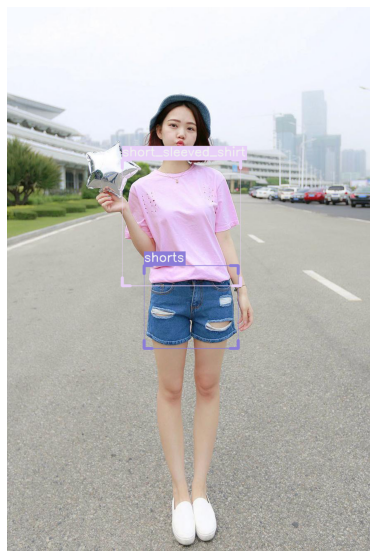

In [9]:
show_record(train_records[10], display_label=True, class_map=class_map, figsize=(10,10))


## Defining augmentations and dataloaders

Handy config and hyperparameters: [**OmegaConf**](https://github.com/omry/omegaconf)

In [10]:
from omegaconf import OmegaConf

In [11]:
params = OmegaConf.create({
    'project': 'deepfashion',
    'run_name': 'presentation',
    'img_size': 512,
    'num_classes': len(class_map),
    'bs': 4,
    'num_workers': 4,
    'path': './datasets',
    'model_name': 'tf_efficientdet_d1'
})

\
Limiting rotation angle

In [13]:
aug_tfms = tfms.A.aug_tfms(
    size=params.img_size,
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=(-15, 15)),
)
aug_tfms.append(tfms.A.Normalize())

\
Let's see what our augmentations are

In [14]:
aug_tfms

[HorizontalFlip(always_apply=False, p=0.5),
 ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None),
 RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
 RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
 Blur(always_apply=False, p=0.5, blur_limit=(1, 3)),
 OneOrOther([
   RandomSizedBBoxSafeCrop(always_apply=False, p=0.5, height=512, width=512, erosion_rate=0.0, interpolation=1),
   LongestMaxSize(always_apply=False, p=1, max_size=512, interpolation=1),
 ], p=0.5),
 PadIfNeeded(always_apply=False, p=1.0, min_height=512, min_width=512, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=[124, 116, 104], mask_value=None),
 Normalize

\
Coupling it together

In [15]:
train_tfms = tfms.A.Adapter(aug_tfms)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params.img_size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = efficientdet.train_dl(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)

## Looking at the batch

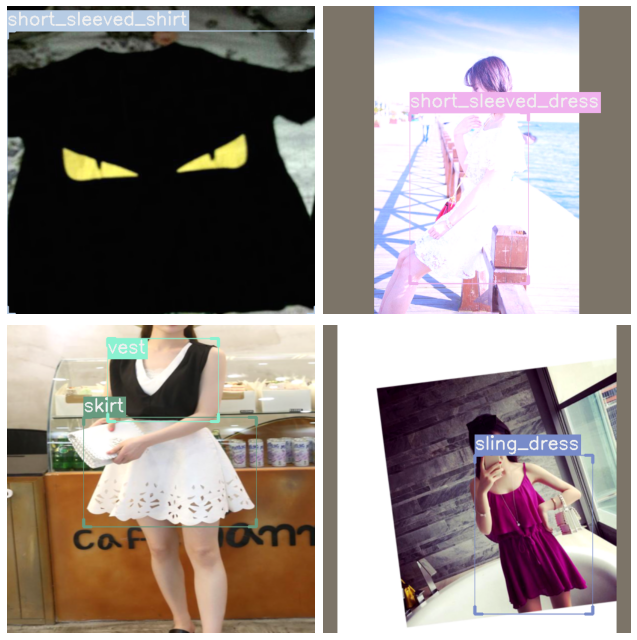

In [16]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=2, figsize=(9,9))

&nbsp;
# EfficientDet Model
<img src="./assets/efficientdet.png" width=600/>
<img src="./assets/efficientdet_table.png" width=600/>

## Following the tutorial...

In [ ]:
print(OmegaConf.to_yaml(params))

In [40]:
model = efficientdet.model(model_name=params.model_name, num_classes=params.num_classes, img_size=params.img_size)
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [41]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.02290867641568184)

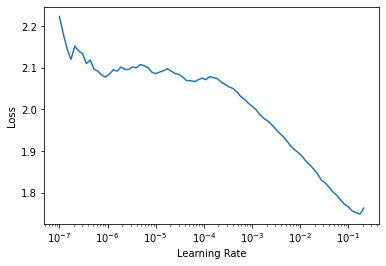

In [42]:
learn.freeze()
learn.lr_find()

<img src="./assets/pepe-happy.jpeg" width=80/>

In [44]:
from fastai.learner import AvgLoss
from fastai.torch_core import find_bs

@patch
def accumulate(self:AvgLoss, learn):
    #bs = find_bs(learn.yb)
    bs = find_bs(learn.xb)
    self.total += learn.to_detach(learn.loss.mean())*bs
    self.count += bs

In [ ]:
learn.fine_tune(10, 1e-2, freeze_epochs=3)

<details>
    <summary>nan</summary>
<img src="./assets/fastai-nan.png" width=600/>
</details>

<details>
    <summary>github issue</summary>
    <img src="./assets/nan-github.png" width=900/>
    <br>
    <img src="./assets/sad-face.png" width=80/>
</details>

In [ ]:
halt **restart notebook**

## Timm to the rescue!
Here is where the fun part begins. 
Training efficientdet models with [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) library.

```python
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler


@dataclass
class TimmConfig:
    opt:str = 'fusedmomentum'
    weight_decay:float = 4e-5
    lr: float = 0.01
    momentum: float = 0.9

    opt_eps: float = 1e-3
    # opt_betas
    # opt_args

    epochs: int = 300
    lr_noise: tuple = (0.4, 0.9)
    sched: str = 'cosine'
    min_lr: float = 1e-5
    decay_rate: float = 0.1
    warmup_lr: float = 1e-4
    warmup_epochs: int = 5
    cooldown_epochs: int = 10

    lr_cycle_limit:int = 1
    lr_cycle_mul: float = 1.0
    lr_noise_pct: float = 0.67
    lr_noise_std: float = 1.0
    seed: int = 42

# Pytorch lightning
class BaseModel(efficientdet.lightning.ModelAdapter):
    def __init__(self, model: nn.Module, metrics: List[Any] = None, **timm_args):
        super(BaseModel, self).__init__(model=model, metrics=metrics)
        self.n_train_dls, self.n_test_dls, self.n_valid_dls = None, None, None
        self.timm_config = TimmConfig(**timm_args)

    def configure_optimizers(self):
        optimizer = create_optimizer(self.timm_config, self.model)
        lr_scheduler, num_epochs = create_scheduler(self.timm_config, optimizer)
        return [optimizer], [lr_scheduler]
```

It was almost as simple as that!  
Pending PR (https://github.com/PyTorchLightning/pytorch-lightning/pull/5898)

## Transfer learning

Thanks to IceVision being backend agnostic, everything we created so far will still work in pytorch lightning!

In [ ]:
from icevision_detector import *

In [ ]:
light_model = EffDetModel(
    num_classes=params.num_classes, img_size=params.img_size, model_name=params.model_name,
    lr=0.12, warmup_epochs=2)

## Freezing/unfreezing

In [ ]:
light_model.freeze_to_head(True, True)

In [ ]:
trainer = pl.Trainer(
    # limit_train_batches=1000,
    # limit_val_batches=100,
    gpus=1,
    max_epochs=3,
    sync_batchnorm=True,  # from Ross'es training config
    weights_summary='full'
)

## Training

In [ ]:
trainer.fit(light_model, train_dl, valid_dl)

<img src="./assets/pepe-happy.jpeg" width=80/>

&nbsp;
&nbsp;

# Going big
- we've read our label files and created the records
- we defined transforms and dataloaders
- we defined optimizers and schedulers
- we chose the model and used pretrained weights


## Experiment tracking with wandb
<img src="./assets/wandb_plot.png" width=600/>

In [ ]:
from pytorch_lightning.loggers import WandbLogger

In [ ]:
wandb_logger = WandbLogger(project=params.project, name=params.run_name)

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [ ]:
lr_monitor = LearningRateMonitor(log_momentum=True)

## Setup model checkpointing

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
checkpoint_callback = ModelCheckpoint(
    verbose=True,
    monitor='COCOMetric/AP (IoU=0.50) area=all/dl_idx_0',
    mode='max'
)

## Multi-GPU training

In [ ]:
trainer = pl.Trainer(
    gpus=2,
    accelerator='ddp',
    logger=wandb_logger,
    callbacks=[lr_monitor, checkpoint_callback],
    max_epochs=300, # caveat
    sync_batchnorm=True,  # from Ross'es training config
    weights_summary='full',
    amp_level='O2', 
    precision=16,
)

<details>
    <summary>well</summary>
<img src="./assets/guess.jpg" width=400/>
</details>

In [ ]:
trainer.fit(light_model, train_dl, valid_dl)

## Exporting training script

In [ ]:
!jupyter nbconvert \
    --TagRemovePreprocessor.enabled=True \
    --TagRemovePreprocessor.remove_cell_tags="['no-script']" \
    --TemplateExporter.exclude_markdown=True \
    --to python "presentation-25.02.20.ipynb" \
    --output "train.py"

...and let's take a look

## Exporting environment files

```bash
conda env export > environment.yml
```

In [ ]:
!cat environment.yml

In [ ]:
!cat requirements.txt

```
```
# Deployment
## Inference
## gradio model deployment

# *Impressing your supervisor with wandb reports*